<a href="https://colab.research.google.com/github/SmrutiRanjan27/Cardiovascular-Risk-Prediction/blob/main/Cardiovascular_Risk_Prediction_Smruti_Ranjan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
file_dir = '/content/drive/MyDrive/AlmaBetter/Cohort Nilgiri/Module 4/Capstone Project/data/'
df = pd.read_csv(file_dir + 'data_cardiovascular_risk.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [ ]:
# lets check for distribution of classes
class_0_count, class_1_count = df[df['TenYearCHD']==0].shape[0], df[df['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


There are 17 columns in the dataset. Out of which 15 are attributes/features, column 0 is the id of each sample, and column 16 is the target variable. Before doing some data cleaning and EDA, lets split our dataset into train and test data.<br>

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['TenYearCHD'], random_state = 1)

In [ ]:
train_df.shape

(2712, 17)

In [ ]:
test_df.shape

(678, 17)

# **Exploratory Data Analysis**
----------------------------------
<br>

## **Categorical Variables**

* **Data cleaning - null values imputation**

In [ ]:
cat_features = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [ ]:
simp_imputer = SimpleImputer(strategy="most_frequent")
simp_imputer.fit(train_df[cat_features])
train_df[cat_features]= simp_imputer.transform(train_df[cat_features])
test_df[cat_features]= simp_imputer.transform(test_df[cat_features])

### **Education**

In [ ]:
train_df.education.unique()

array([2., 3., 1., 4.])

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

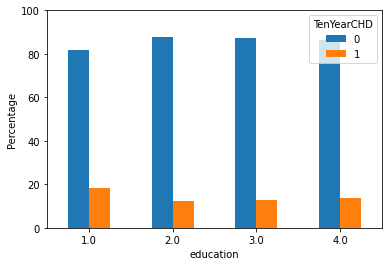

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
prob = 0.99
alpha = 1.0 - prob

In [ ]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_df)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0006802
Categorical variables are dependent


True

### **Sex**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

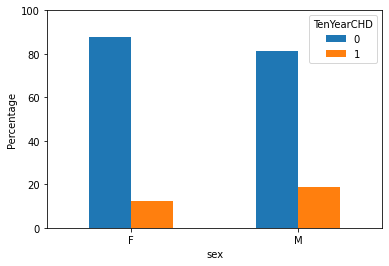

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

**Higher fraction of males are prone to cardiovascular diseases!**

### **Smoking**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

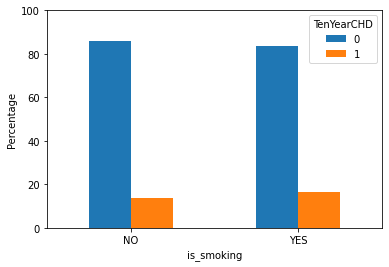

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False

**Statistically smoking has no impact on 10-year risk of CHD**

### **BP Meds**

In [ ]:
train_df.BPMeds.unique()

array([0., 1.])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

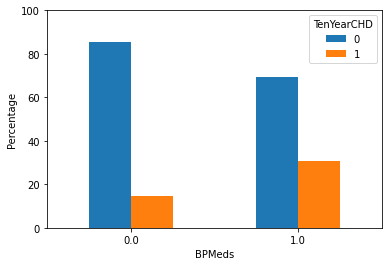

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['BPMeds'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0001078
Categorical variables are dependent


True

**People who take Blood pressure meds have a higher chance of having CHD**

### **Prevalent Stroke**

In [ ]:
train_df.prevalentStroke.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

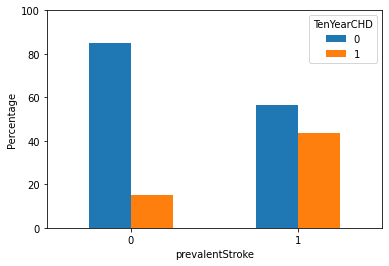

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['prevalentStroke'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0041885
Categorical variables are dependent


True

**Higher percentage of patients with prevalent stroke symptoms have a 10-year risk of CHD.**

### **Prevalent Hypertension**

In [ ]:
train_df.prevalentHyp.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

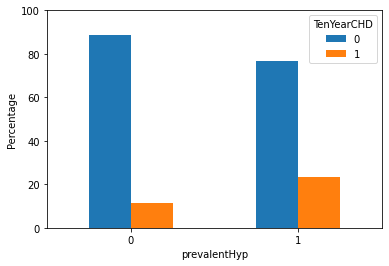

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['prevalentHyp'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0000000
Categorical variables are dependent


True

**Hypertensive patients are at higher risk of CHD**

### **Diabetes**

In [ ]:
train_df.diabetes.unique()

array([0, 1])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

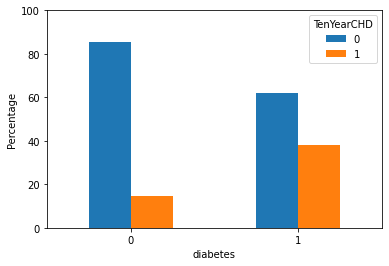

In [ ]:
freq_df = train_df.groupby('TenYearCHD')['diabetes'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [ ]:
cat_dependency(freq_df)

significance=0.010, p=0.0000004
Categorical variables are dependent


True

**Diabetic patients tend to have a higher 10-year risk of CHD**


## **Continuous Variables**

* **Data cleaning - null values imputation**

In [ ]:
cont_features = ['age', 'totChol', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [ ]:
knn_imputer= KNNImputer(n_neighbors=5)
knn_imputer.fit(train_df[cont_features])
train_df[cont_features]= knn_imputer.transform(train_df[cont_features])
test_df[cont_features]= knn_imputer.transform(test_df[cont_features])

### **Age**

In [ ]:
train_df.age.unique()

array([49., 51., 57., 59., 52., 60., 48., 40., 54., 39., 56., 44., 42.,
       43., 41., 45., 37., 61., 53., 62., 47., 36., 55., 34., 46., 64.,
       38., 58., 63., 35., 50., 65., 67., 66., 68., 33., 69., 70., 32.])

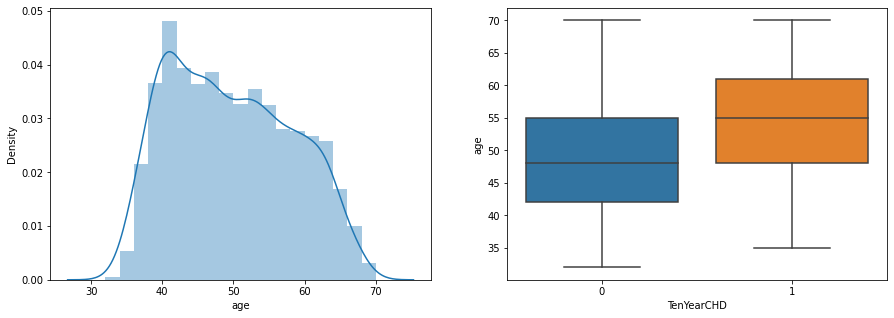

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['age'], ax=axes[0])
sns.boxplot(y='age',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
# using one-way ANOVA test to determine dependency between continuous variables and the target categorical variable
def cont_dependency(feature,alpha=alpha):
  F, p = f_oneway(train_df[train_df['TenYearCHD'] == 1][feature], train_df[train_df['TenYearCHD'] == 0][feature])
  print('significance=%.3f, p=%.5f' % (alpha, p))
  if p <= alpha:
    print('Ten year Risk of CHD is dependent on the continuous variable')
    return True
  else:
    print('Ten year Risk of CHD is not dependent on continuous variable')
    return False

In [ ]:
cont_dependency('age')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing age feature**

In [ ]:
train_df['age_bucket'] = train_df['age'].apply(lambda x : 5*(x//5))

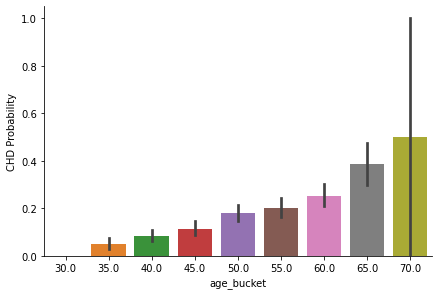

In [ ]:
ax=sns.factorplot('age_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**The positive CHD cases seems to be more prevalent in older people.**

### **Cigarrettes per Day**

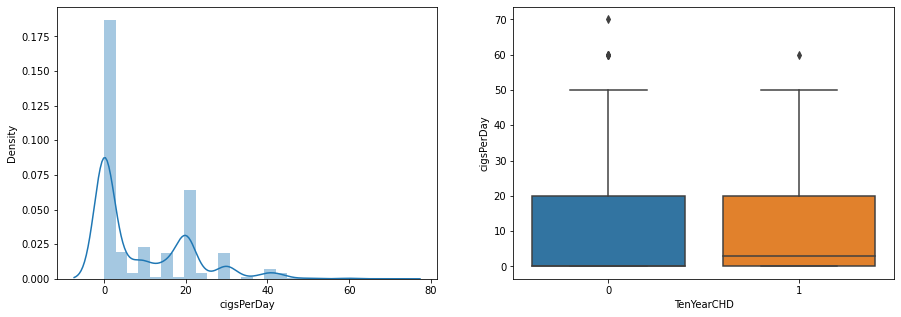

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['cigsPerDay'], ax=axes[0])
sns.boxplot(y='cigsPerDay',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
cont_dependency('cigsPerDay')

significance=0.010, p=0.00184
Ten year Risk of CHD is dependent on the continuous variable


True

**We see that the median is slighlty higher for the positive cases, which means people who smoke higher number of cigarette per day, tend to show cardio-vascular disease!**

### **Total Cholestrol level**

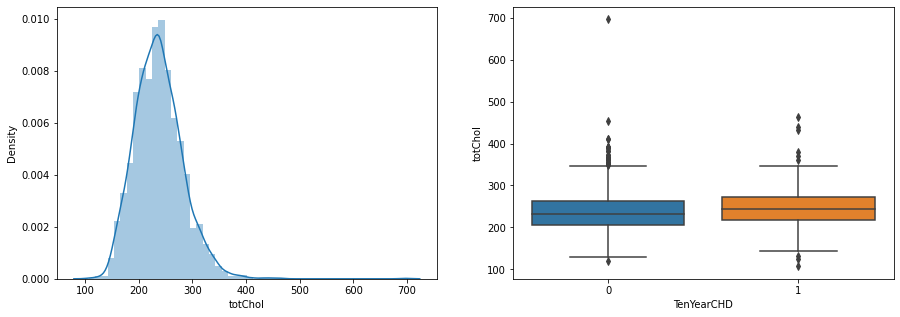

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
#dealing with outliers
vals = train_df.totChol.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_df['totChol'] = train_df['totChol'].apply(lambda x : x if x > min_lim and x < max_lim else train_df['totChol'].median())

0.25    206.00
0.75    264.25
Name: totChol, dtype: float64


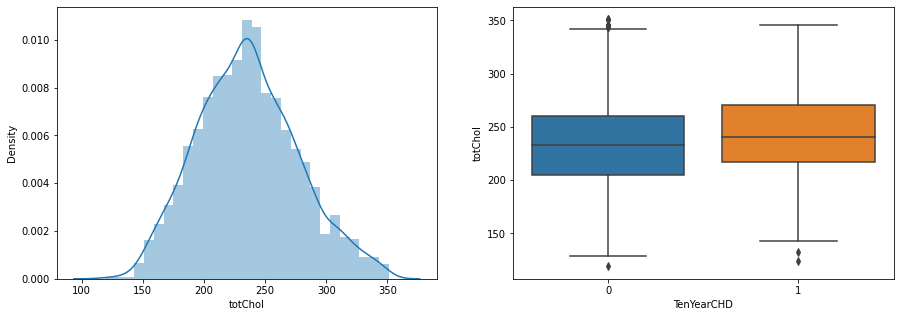

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
cont_dependency('totChol')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Total cholestrol feature**

In [ ]:
train_df['chol_bucket'] = train_df['totChol'].apply(lambda x : 40*(x//40))

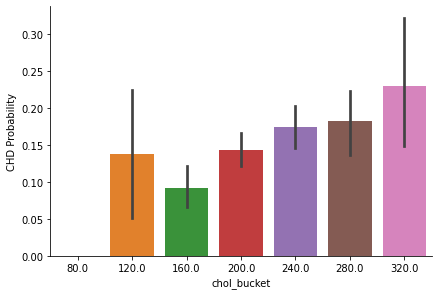

In [ ]:
ax = sns.factorplot('chol_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

### **Systolic and diastolic BP**

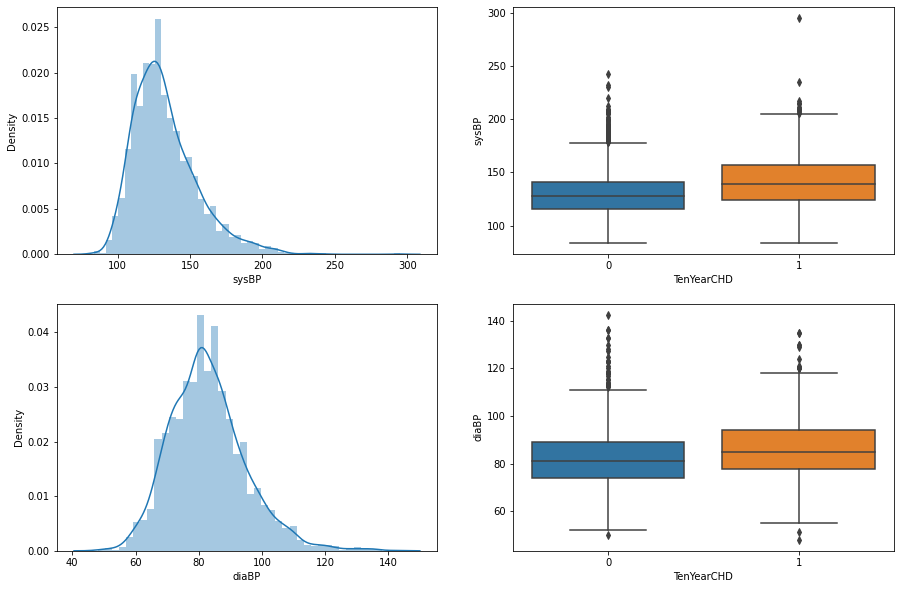

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.distplot(train_df['sysBP'], ax=axes[0,0])
sns.boxplot(y='sysBP',x='TenYearCHD',data=train_df, ax=axes[0,1])
sns.distplot(train_df['diaBP'], ax=axes[1,0])
sns.boxplot(y='diaBP',x='TenYearCHD',data=train_df, ax=axes[1,1])

In [ ]:
cont_dependency('sysBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [ ]:
cont_dependency('diaBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Systolic BP feature**

In [ ]:
train_df['sysBP_bucket'] = train_df['sysBP'].apply(lambda x : 30*(x//30))

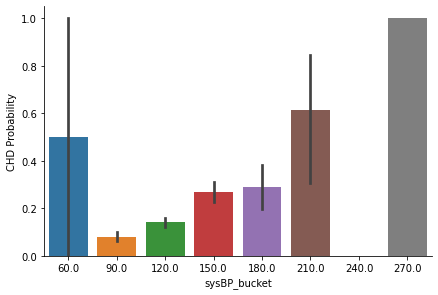

In [ ]:
ax = sns.factorplot('sysBP_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

**We see a slighlty positive inclination of CHD risk towards high systolic and diastolic Blood pressure.**

### **Body Mass Index (BMI)**

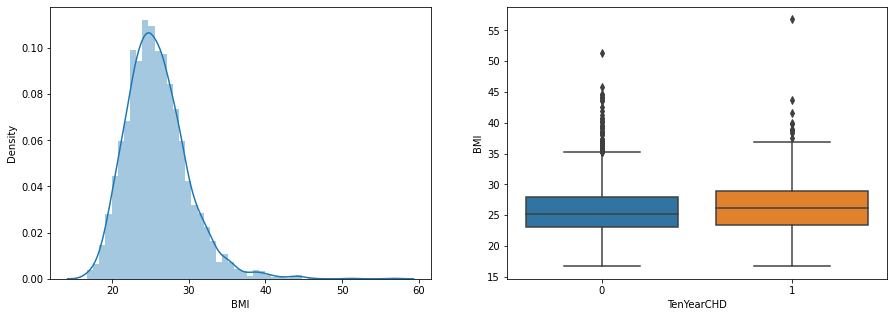

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['BMI'], ax=axes[0])
sns.boxplot(y='BMI',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
cont_dependency('BMI')

significance=0.010, p=0.00279
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing BMI feature**

In [ ]:
train_df['bmi_bucket'] = train_df['BMI'].apply(lambda x : 3*(x//3))

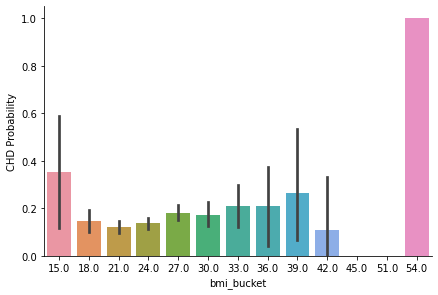

In [ ]:
ax = sns.factorplot('bmi_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

### **Heart Rate**

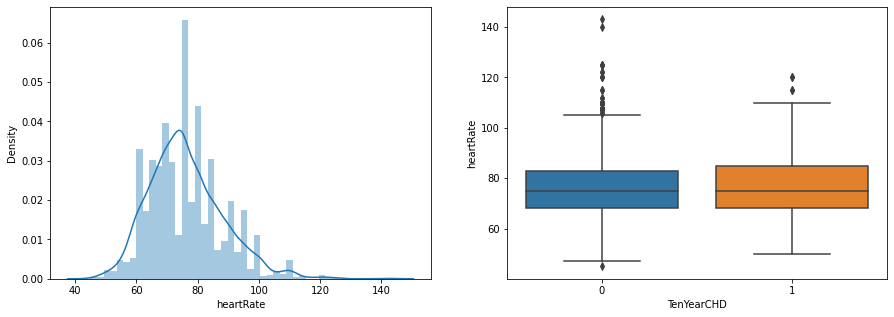

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['heartRate'], ax=axes[0])
sns.boxplot(y='heartRate',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
cont_dependency('heartRate')

significance=0.010, p=0.16756
Ten year Risk of CHD is not dependent on continuous variable


False

**Bucketing heart Rate Feature**

In [ ]:
train_df['hr_bucket'] = train_df['heartRate'].apply(lambda x : 10*(x//10))

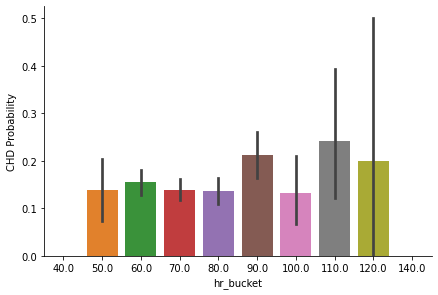

In [ ]:
ax = sns.factorplot('hr_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

### **Glucose**

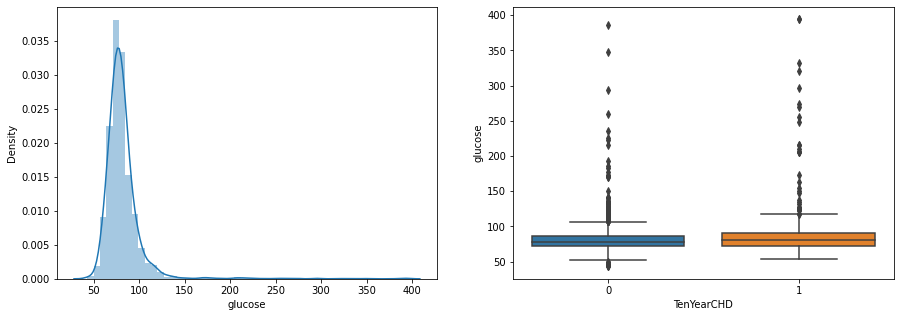

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['glucose'], ax=axes[0])
sns.boxplot(y='glucose',x='TenYearCHD',data=train_df, ax=axes[1])

In [ ]:
cont_dependency('glucose')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [ ]:
train_df['glucose_bucket'] = train_df['glucose'].apply(lambda x : 50*(x//50))

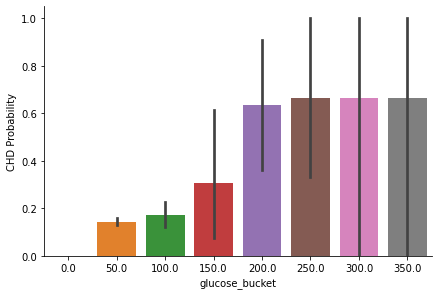

In [ ]:
ax = sns.factorplot('glucose_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2712 non-null   int64  
 1   age              2712 non-null   float64
 2   education        2712 non-null   float64
 3   sex              2712 non-null   object 
 4   is_smoking       2712 non-null   object 
 5   cigsPerDay       2712 non-null   float64
 6   BPMeds           2712 non-null   float64
 7   prevalentStroke  2712 non-null   int64  
 8   prevalentHyp     2712 non-null   int64  
 9   diabetes         2712 non-null   int64  
 10  totChol          2712 non-null   float64
 11  sysBP            2712 non-null   float64
 12  diaBP            2712 non-null   float64
 13  BMI              2712 non-null   float64
 14  heartRate        2712 non-null   float64
 15  glucose          2712 non-null   float64
 16  TenYearCHD       2712 non-null   int64  
 17  age_bucket   

# **Dependencies between Independent variables - Check for multicollinearity**

In [ ]:
def cat_dependency_matrix(cols, alpha=alpha, verbose=False):
  cat_matrix = np.zeros((cols.shape[0], cols.shape[0]))
  print(cat_matrix.shape)
  for i,col in enumerate(cols):
    for j,col in enumerate(cols):
      if i != j:
        cat_matrix[i,j] = int(cat_dependency(train_df.groupby(cols[j])[cols[i]].value_counts().unstack(0), alpha=alpha, verbose=verbose))
      else:
        cat_matrix[i,j] = 1.
  return pd.DataFrame(cat_matrix, columns=cols, index=cols, dtype=int)

In [ ]:
cat_cols = np.array(['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'])
cat_dependency_matrix(cat_cols, alpha=0.01, verbose=False)

(7, 7)


,education,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes
education,1,1,1,0,0,1,1
sex,1,1,1,0,0,0,0
is_smoking,1,1,1,0,0,1,1
BPMeds,0,0,0,1,1,0,1
prevalentStroke,0,0,0,1,1,1,0
prevalentHyp,1,0,1,0,1,1,1
diabetes,1,0,1,1,0,1,1


**Lets look at correlation matrix of categorical variables as well !**

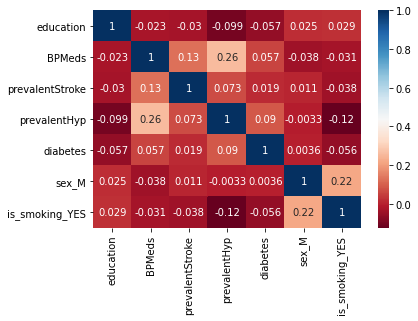

In [ ]:
train_cat_df = pd.get_dummies(train_df[cat_cols], drop_first=True) 
sns.heatmap(train_cat_df.corr(), cmap='RdBu', annot=True)

In [ ]:
#lets check vif scores
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [ ]:
ignore_features = ['education']
train_cat_df_ = train_cat_df[[col for col in train_cat_df.columns if col not in ignore_features]]
calc_vif(train_cat_df_)

,variables,VIF
0,BPMeds,1.123208
1,prevalentStroke,1.025231
2,prevalentHyp,1.310147
3,diabetes,1.030597
4,sex_M,1.597393
5,is_smoking_YES,1.539392


**Based on the VIF scores, I can safely remove education feature.**

**Lets look at correlation matrix of Continuous variables**

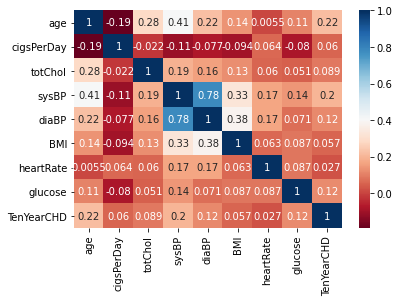

In [ ]:
cont_cols = np.array(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'])
sns.heatmap(train_df[cont_cols].corr(), cmap='RdBu', annot=True)

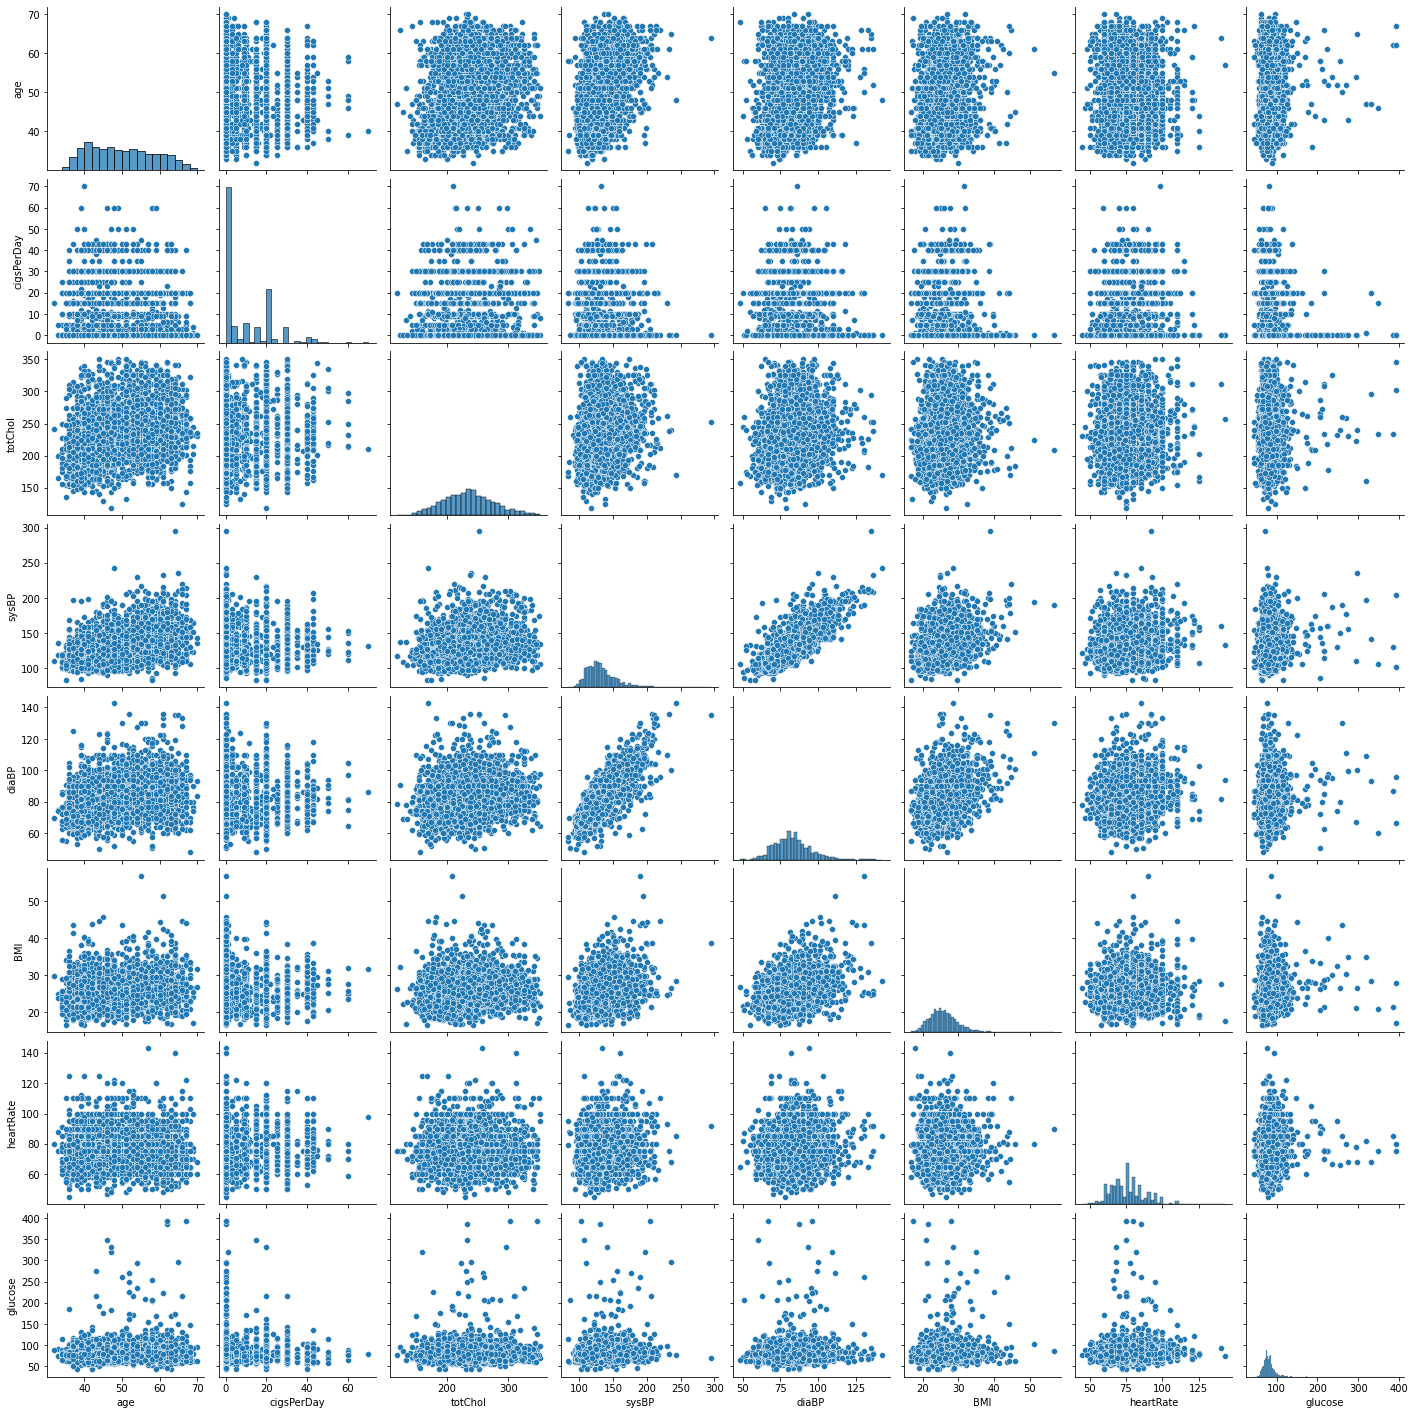

In [ ]:
sns.pairplot(train_df[cont_cols[:-1]])

In [ ]:
ignore_features = ['TenYearCHD','diaBP']
train_cont_df = train_df[[col for col in cont_cols if col not in ignore_features]]
calc_vif(train_cont_df)

,variables,VIF
0,age,41.049805
1,cigsPerDay,1.621425
2,totChol,34.108171
3,sysBP,49.471280
4,BMI,39.070687
5,heartRate,33.297511
6,glucose,13.291682


**There was a significantly higher correlation between systolic BP and diastolic BP. Based on correlation matrix and VIF scores, I safely remove diabolic BP feature.**

**Lets look at the correlation matrix of all the remaining features and see if there are any correlations left**

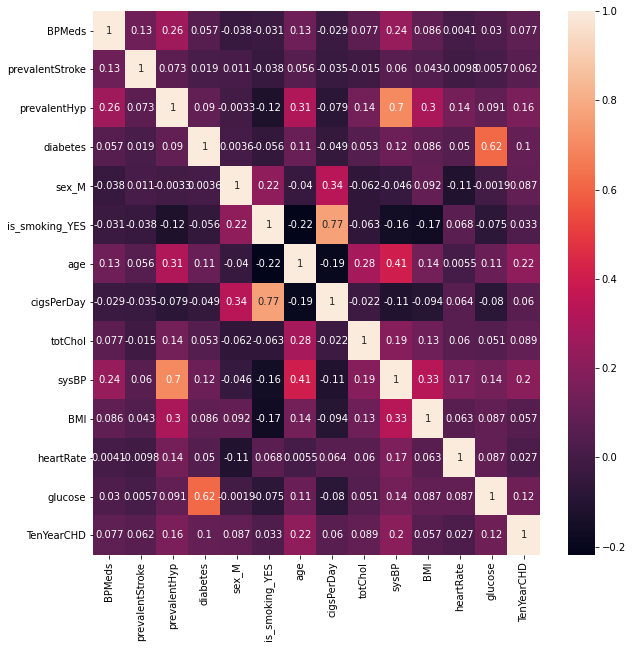

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
tot_df = pd.concat((train_cat_df_, train_cont_df, train_df['TenYearCHD']), axis =1)
sns.heatmap(tot_df.corr(), annot=True, ax= ax)

**There is significant correlation between sysBP, prevalent hypertension and age. Also features like is smoking and ciggarettes per day are correlated. Similarly glucose level and diabetes are correlated. Based on the EDA done earlier, smoking and heart Rate seem to have little to no impact on the target variable.**

**Preparing final train dataset**

In [ ]:
final_features = np.concatenate((train_cat_df_.columns.values, train_cont_df.columns.values, ['education','diaBP','TenYearCHD']))

In [ ]:
#imputer = KNNImputer(n_neighbors=5)
final_train_df = pd.get_dummies(train_df,drop_first=True)[final_features]
#s = imputer.fit_transform(final_train_df)
#final_train_df = pd.DataFrame(s, columns = final_train_df.columns)

In [ ]:
final_train_df.head()

,BPMeds,prevalentStroke,prevalentHyp,diabetes,sex_M,is_smoking_YES,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,education,diaBP,TenYearCHD
542,0.0,0,0,0,0,1,49.0,20.0,229.0,118.5,21.42,76.0,76.4,2.0,76.5,0
2726,0.0,0,0,0,1,0,51.0,0.0,215.0,147.0,28.59,65.0,100.0,3.0,96.0,0
3067,0.0,0,1,0,0,1,57.0,1.0,254.0,146.5,41.61,72.0,85.0,1.0,81.0,1
204,1.0,0,1,0,0,0,59.0,0.0,282.0,135.0,28.96,72.0,89.0,4.0,87.0,0
329,0.0,0,0,0,0,0,52.0,0.0,275.0,112.0,25.68,80.0,80.4,1.0,71.0,0


In [ ]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BPMeds           2712 non-null   float64
 1   prevalentStroke  2712 non-null   int64  
 2   prevalentHyp     2712 non-null   int64  
 3   diabetes         2712 non-null   int64  
 4   sex_M            2712 non-null   uint8  
 5   is_smoking_YES   2712 non-null   uint8  
 6   age              2712 non-null   float64
 7   cigsPerDay       2712 non-null   float64
 8   totChol          2712 non-null   float64
 9   sysBP            2712 non-null   float64
 10  BMI              2712 non-null   float64
 11  heartRate        2712 non-null   float64
 12  glucose          2712 non-null   float64
 13  education        2712 non-null   float64
 14  diaBP            2712 non-null   float64
 15  TenYearCHD       2712 non-null   int64  
dtypes: float64(10), int64(4), uint8(2)
memory usage: 403.1 KB


**Preparing our test dataset based on the selected features and the imputed missing values from training dataset.**

In [ ]:
final_test_df = pd.get_dummies(test_df,drop_first=True)[final_features]
#s = imputer.transform(final_test_df)
#final_test_df = pd.DataFrame(s, columns = final_test_df.columns)

In [ ]:
X_train, y_train = final_train_df.iloc[:,:-1], final_train_df.iloc[:,-1]
X_test, y_test = final_test_df.iloc[:,:-1], final_test_df.iloc[:,-1]

In [ ]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns)

### **ML Modelling and addressing Class imbalance**

**Logistic Regression**

* **Random oversampler + Logistic Regression**

In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
lr_model = LogisticRegression().fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

ROCAUC score: 0.6851511437908496
Recall score: 0.6862745098039216

               precision    recall  f1-score   support

           0       0.92      0.68      0.79       576
           1       0.28      0.69      0.40       102

    accuracy                           0.68       678
   macro avg       0.60      0.69      0.59       678
weighted avg       0.83      0.68      0.73       678


 [[394 182]
 [ 32  70]]


 * **StratifiedKFold + oversampling + logistic regression**

In [ ]:
lr_model = LogisticRegression()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  lr_model.fit(X_ros, y_ros)
  lr_predict = lr_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, lr_predict))
  i+=1
 
lr_y_predict = lr_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))

CV 1:  0.5487804878048781
CV 2:  0.6951219512195121
CV 3:  0.7037037037037037
CV 4:  0.6707317073170732
CV 5:  0.6707317073170732

Test results:
ROCAUC score: 0.6799428104575164
Recall score: 0.6862745098039216

               precision    recall  f1-score   support

           0       0.92      0.67      0.78       576
           1       0.27      0.69      0.39       102

    accuracy                           0.68       678
   macro avg       0.60      0.68      0.58       678
weighted avg       0.83      0.68      0.72       678



* **SMOTE + Logistic Regression**

In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
lr_model = LogisticRegression().fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

ROCAUC score: 0.6909211601307189
Recall score: 0.696078431372549

               precision    recall  f1-score   support

           0       0.93      0.69      0.79       576
           1       0.28      0.70      0.40       102

    accuracy                           0.69       678
   macro avg       0.60      0.69      0.59       678
weighted avg       0.83      0.69      0.73       678


 [[395 181]
 [ 31  71]]


* **GridSearch CV on logistic**

In [ ]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [ ]:
lr_model = LogisticRegression()
grid_model = GridSearchCV(lr_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_smote,y_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [ ]:
grid_model.best_params_

{'C': 10.0}

In [ ]:
lr_model = grid_model.best_estimator_

In [ ]:
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

ROCAUC score: 0.6811172385620915
Recall score: 0.6764705882352942

               precision    recall  f1-score   support

           0       0.92      0.69      0.79       576
           1       0.28      0.68      0.39       102

    accuracy                           0.68       678
   macro avg       0.60      0.68      0.59       678
weighted avg       0.83      0.68      0.73       678


 [[395 181]
 [ 33  69]]


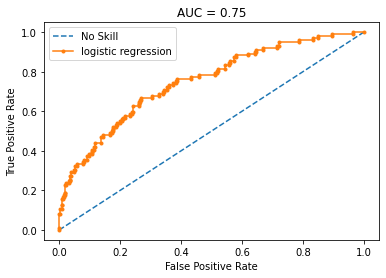

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='logistic regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(lr_fpr, lr_tpr))
plt.legend()
plt.show()

**K-Nearest Neighbors**

* **RandomSampler + KNN**

In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
knn_model = KNeighborsClassifier(weights='uniform').fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
knn_y_predict = knn_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

ROCAUC score: 0.6321486928104575
Recall score: 0.5490196078431373

               precision    recall  f1-score   support

           0       0.90      0.72      0.80       576
           1       0.25      0.55      0.35       102

    accuracy                           0.69       678
   macro avg       0.58      0.63      0.57       678
weighted avg       0.80      0.69      0.73       678


 [[412 164]
 [ 46  56]]


 * **StratifiedKFold + oversampling + KNN**

In [ ]:
 knn_model = KNeighborsClassifier()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  knn_model.fit(X_ros, y_ros)
  knn_predict = knn_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, knn_predict))
  i+=1
 
knn_y_predict = knn_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))

CV 1:  0.4146341463414634
CV 2:  0.43902439024390244
CV 3:  0.4444444444444444
CV 4:  0.4634146341463415
CV 5:  0.45121951219512196

Test results:
ROCAUC score: 0.6085069444444444
Recall score: 0.5

               precision    recall  f1-score   support

           0       0.89      0.72      0.79       576
           1       0.24      0.50      0.32       102

    accuracy                           0.68       678
   macro avg       0.56      0.61      0.56       678
weighted avg       0.79      0.68      0.72       678



* **SMOTE + KNN**

In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
knn_model = KNeighborsClassifier().fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
knn_y_predict = knn_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

ROCAUC score: 0.6058517156862745
Recall score: 0.5294117647058824

               precision    recall  f1-score   support

           0       0.89      0.68      0.77       576
           1       0.23      0.53      0.32       102

    accuracy                           0.66       678
   macro avg       0.56      0.61      0.55       678
weighted avg       0.79      0.66      0.70       678


 [[393 183]
 [ 48  54]]


* **GridSearch CV on KNN**

In [ ]:
params = {
    'n_neighbors' : range(3,10,1),
    'weights' : ['uniform', 'distance']
    }

In [ ]:
knn_model = KNeighborsClassifier()
grid_model = GridSearchCV(knn_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_ros,y_ros)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(3, 10),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [ ]:
grid_model.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [ ]:
knn_model = grid_model.best_estimator_

In [ ]:
knn_y_predict = knn_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

ROCAUC score: 0.5896139705882353
Recall score: 0.38235294117647056

               precision    recall  f1-score   support

           0       0.88      0.80      0.84       576
           1       0.25      0.38      0.30       102

    accuracy                           0.73       678
   macro avg       0.56      0.59      0.57       678
weighted avg       0.78      0.73      0.76       678


 [[459 117]
 [ 63  39]]


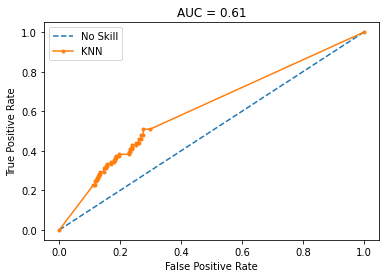

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
knn_probs = knn_model.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(knn_fpr, knn_tpr))
plt.legend()
plt.show()

**Support Vector Machines**

* **Using the imabalnced dataset in SVC with class_weight='balanced', i.e. penalizing misclassifications in each class approriately !**

In [ ]:
# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)
 
svc_model.fit(X_train, y_train)
 
svc_predict = svc_model.predict(X_test)
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Recall score:',recall_score(y_test, svc_predict))
print('\n', classification_report(y_test, svc_predict))
print('\n', confusion_matrix(y_test, svc_predict))

ROCAUC score: 0.6661049836601307
Recall score: 0.6568627450980392

               precision    recall  f1-score   support

           0       0.92      0.68      0.78       576
           1       0.26      0.66      0.38       102

    accuracy                           0.67       678
   macro avg       0.59      0.67      0.58       678
weighted avg       0.82      0.67      0.72       678


 [[389 187]
 [ 35  67]]


* **Random over-sampler + SVC**

In [ ]:
svc_model = SVC(probability=True).fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6984272875816995
Recall score: 0.7058823529411765

               precision    recall  f1-score   support

           0       0.93      0.69      0.79       576
           1       0.29      0.71      0.41       102

    accuracy                           0.69       678
   macro avg       0.61      0.70      0.60       678
weighted avg       0.83      0.69      0.74       678


 [[398 178]
 [ 30  72]]


* **StratifiedKFold + oversampling + SVC**

In [ ]:
 svc_model = SVC(probability=True)
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  svc_model.fit(X_ros, y_ros)
  svc_predict = svc_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, svc_predict))
  i+=1
 
svc_y_predict = svc_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))

CV 1:  0.5609756097560976
CV 2:  0.7317073170731707
CV 3:  0.5308641975308642
CV 4:  0.5487804878048781
CV 5:  0.6341463414634146

Test results:
ROCAUC score: 0.6984272875816995
Recall score: 0.7058823529411765

               precision    recall  f1-score   support

           0       0.93      0.69      0.79       576
           1       0.29      0.71      0.41       102

    accuracy                           0.69       678
   macro avg       0.61      0.70      0.60       678
weighted avg       0.83      0.69      0.74       678



* **SMOTE + SVC**

In [ ]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
svc_model = SVC(probability=True).fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6626327614379085
Recall score: 0.6568627450980392

               precision    recall  f1-score   support

           0       0.92      0.67      0.77       576
           1       0.26      0.66      0.37       102

    accuracy                           0.67       678
   macro avg       0.59      0.66      0.57       678
weighted avg       0.82      0.67      0.71       678


 [[385 191]
 [ 35  67]]


* **GridSearchCV on SVC**

In [ ]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [ ]:
svc_model = SVC(class_weight='balanced',probability=True)
grid_model = GridSearchCV(svc_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [ ]:
grid_model.best_params_

{'C': 0.01}

In [ ]:
svc_model = grid_model.best_estimator_

In [ ]:
svc_y_predict = svc_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6725898692810457
Recall score: 0.7549019607843137

               precision    recall  f1-score   support

           0       0.93      0.59      0.72       576
           1       0.25      0.75      0.37       102

    accuracy                           0.62       678
   macro avg       0.59      0.67      0.55       678
weighted avg       0.83      0.62      0.67       678


 [[340 236]
 [ 25  77]]


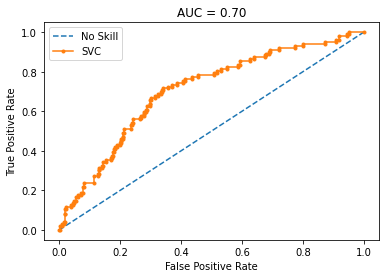

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
svc_probs = svc_model.predict_proba(X_test)
svc_probs = svc_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(svc_fpr, svc_tpr))
plt.legend()
plt.show()

**XGBoost Classifier**

* **Over-sampler + XGBoost**

In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
 
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
xgb_model = XGBClassifier(probability=True).fit(X_ros,y_ros)
xgb_y_predict = xgb_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))
print('\n', confusion_matrix(y_test, xgb_y_predict))

ROCAUC score: 0.6358762254901961
Recall score: 0.5686274509803921

               precision    recall  f1-score   support

           0       0.90      0.70      0.79       576
           1       0.25      0.57      0.35       102

    accuracy                           0.68       678
   macro avg       0.58      0.64      0.57       678
weighted avg       0.80      0.68      0.72       678


 [[405 171]
 [ 44  58]]


* **GridSearchCV on XGBoost**

In [ ]:
params = {
  'max_depth' : range(3,11),
  'gamma' : [0.01, 0.05, 0.1, 0.5, 1.]
}

In [ ]:
xgb_model = XGBClassifier(probability=True)
grid_model = GridSearchCV(xgb_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_ros,y_ros)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     probability=True, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'max_depth': range(3, 11)},
      

In [ ]:
xgb_model = grid_model.best_estimator_

In [ ]:
xgb_y_predict = xgb_model.predict(X_test)
 
print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))
print('\n', confusion_matrix(y_test, xgb_y_predict))

ROCAUC score: 0.5906862745098038
Recall score: 0.2647058823529412

               precision    recall  f1-score   support

           0       0.88      0.92      0.90       576
           1       0.36      0.26      0.31       102

    accuracy                           0.82       678
   macro avg       0.62      0.59      0.60       678
weighted avg       0.80      0.82      0.81       678


 [[528  48]
 [ 75  27]]


# **Conclusion**

**We have used Logistic Regression, KNN, SVC and XGBoost for modelling. Based on our observations, Support vector classifier seems to have performed better with a recall of 0.75, after some hyper-parameter tuning. However the precision of our models still remains a concern.**

**Scope for improvement : Need to work on improving the precision (currently $\sim$ 0.26) of your model to some extent !**